# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [22]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [23]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.4.0


/tmp/ipykernel_8465/189856270.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [24]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [25]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x736068fd4820>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
df = pd.read_pickle('./raw_text.pkl')
print(len(df))
random_idx = random.sample(range(0, len(df)), 10)
descriptions = []
images_path = []
for i in df.iloc[random_idx].iterrows():
    text = i[1][0]
    text = text.replace('<PAD>', '').strip()
    images_path.append(i[0])
    descriptions.append(text)
# images in skimage to use and their textual descriptions
# descriptions = {
#     "page": "a page of text about segmentation",
#     "chelsea": "a facial photo of a tabby cat",
#     "astronaut": "a portrait of an astronaut with the American flag",
#     "rocket": "a rocket standing on a launchpad",
#     "motorcycle_right": "a red motorcycle standing in a garage",
#     "camera": "a person looking at a camera on a tripod",
#     "horse": "a black-and-white silhouette of a horse",
#     "coffee": "a cup of coffee on a saucer"
# }
print(images_path)

7370
['./102flowers/image_02489.jpg', './102flowers/image_03364.jpg', './102flowers/image_00256.jpg', './102flowers/image_03155.jpg', './102flowers/image_00781.jpg', './102flowers/image_04860.jpg', './102flowers/image_03634.jpg', './102flowers/image_03647.jpg', './102flowers/image_01263.jpg', './102flowers/image_06542.jpg']


### Run this block to save all the caption into embeddings.
### Run all the other block to visualize the results

In [ ]:
## Perform to whole dataset
import pandas as pd
df = pd.read_pickle('./raw_text.pkl')
descriptions = []
images_path = []
df_dict = {}
for idx, i in enumerate(df.iterrows()):
    print(idx)
    df_dict[i[0]] = []
    for j in i[1]:
        if j == None:
            break
        text = j
        text = text.replace('<PAD>', '').strip()
        # images_path.append(i[0])
        text_tokens = clip.tokenize(text).cuda()
        with torch.no_grad():
            text_features = model.encode_text(text_tokens).float()
            text_features = text_features.squeeze(0)
        
        df_dict[i[0]].append(text_features.cpu().numpy().tolist())



# original_images = []
# images = []
# texts = []
# for i, filename in enumerate(images_path):
#     name = filename

#     texts.append(descriptions[i])

# text_tokens = clip.tokenize(texts).cuda()
# print("done tokenizing")

# with torch.no_grad():
#     text_features = model.encode_text(text_tokens).float()
# print(text_features.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
## Perform to test dataset
import pandas as pd
df = pd.read_pickle('./test_raw_text.pkl')
captions = []
ids = []
df_dict = {}
print(df.head())
for i in range(len(df)):
    # print(df.iloc[i]['ID'], df.iloc[i]['Captions'])
    id = df.iloc[i]['ID']
    text = df.iloc[i]['Captions']
    text = text.replace('<PAD>', '').strip()
    # print(text)
    text_tokens = clip.tokenize(text).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
        text_features = text_features.squeeze(0)
    # print(text_features.shape)
        
    # df_dict[idx] = text_features.cpu().numpy().tolist()
    ids.append(id)
    captions.append(text_features.cpu().numpy().tolist())
print(len(ids))
print(len(captions), len(captions[0]))

     ID                                           Captions
0  6735  this white and purple flower has fragile petal...
1  6740  this flower has four large wide pink petals wi...
2  6746  a flower with broad white and pink ribbed peta...
3  6759  one prominet pistil with alarger stigam and ma...
4  6762  leaves are green in color petals are light pin...
819
819 512


In [29]:
# df_dict.to_pickle('./clip_text_features.pkl')
# back_to_df = pd.DataFrame.from_dict(df_dict, orient='index')
# print(back_to_df.head)
# back_to_df.to_pickle('./clip_test_text_features.pkl')
d = {'ID': ids, 'Captions': captions}
save_df = pd.DataFrame(d)
save_df.to_pickle('./clip_test_text_features.pkl')
print(save_df.head())

# print(len(df_dict[0]))
# for i in df_dict[0]:
#     print(i)
#     print(np.array(i).shape)
#     break

     ID                                           Captions
0  6735  [-0.1934814453125, -0.143310546875, 0.38208007...
1  6740  [-0.31982421875, 0.177978515625, 0.40551757812...
2  6746  [-0.320556640625, 0.1409912109375, 0.225341796...
3  6759  [-0.2919921875, -0.1639404296875, 0.0973510742...
4  6762  [-0.10345458984375, 0.048187255859375, 0.29833...


['this flower is white and pink in color with petals that are yellow near the ovary', 'a flower with small yellow petals and yellow anther filaments visible', 'this flower is yellow in color with petals that are multi shaped', 'this flower has petals that are purple white and stringy', 'the flower is pale pink and has a white center and yellow stamen', 'the flower has orange and yellow petals with a dark red stigma and green pedicel', 'the anthers are in the center with yellow and orange petals that are perforated on the borders', 'this lush flower features light orange petals and a normal erect pistil', 'this flower has orange petals and pistil as its main features', 'this flower has petals that are red with a long flowery stigma']


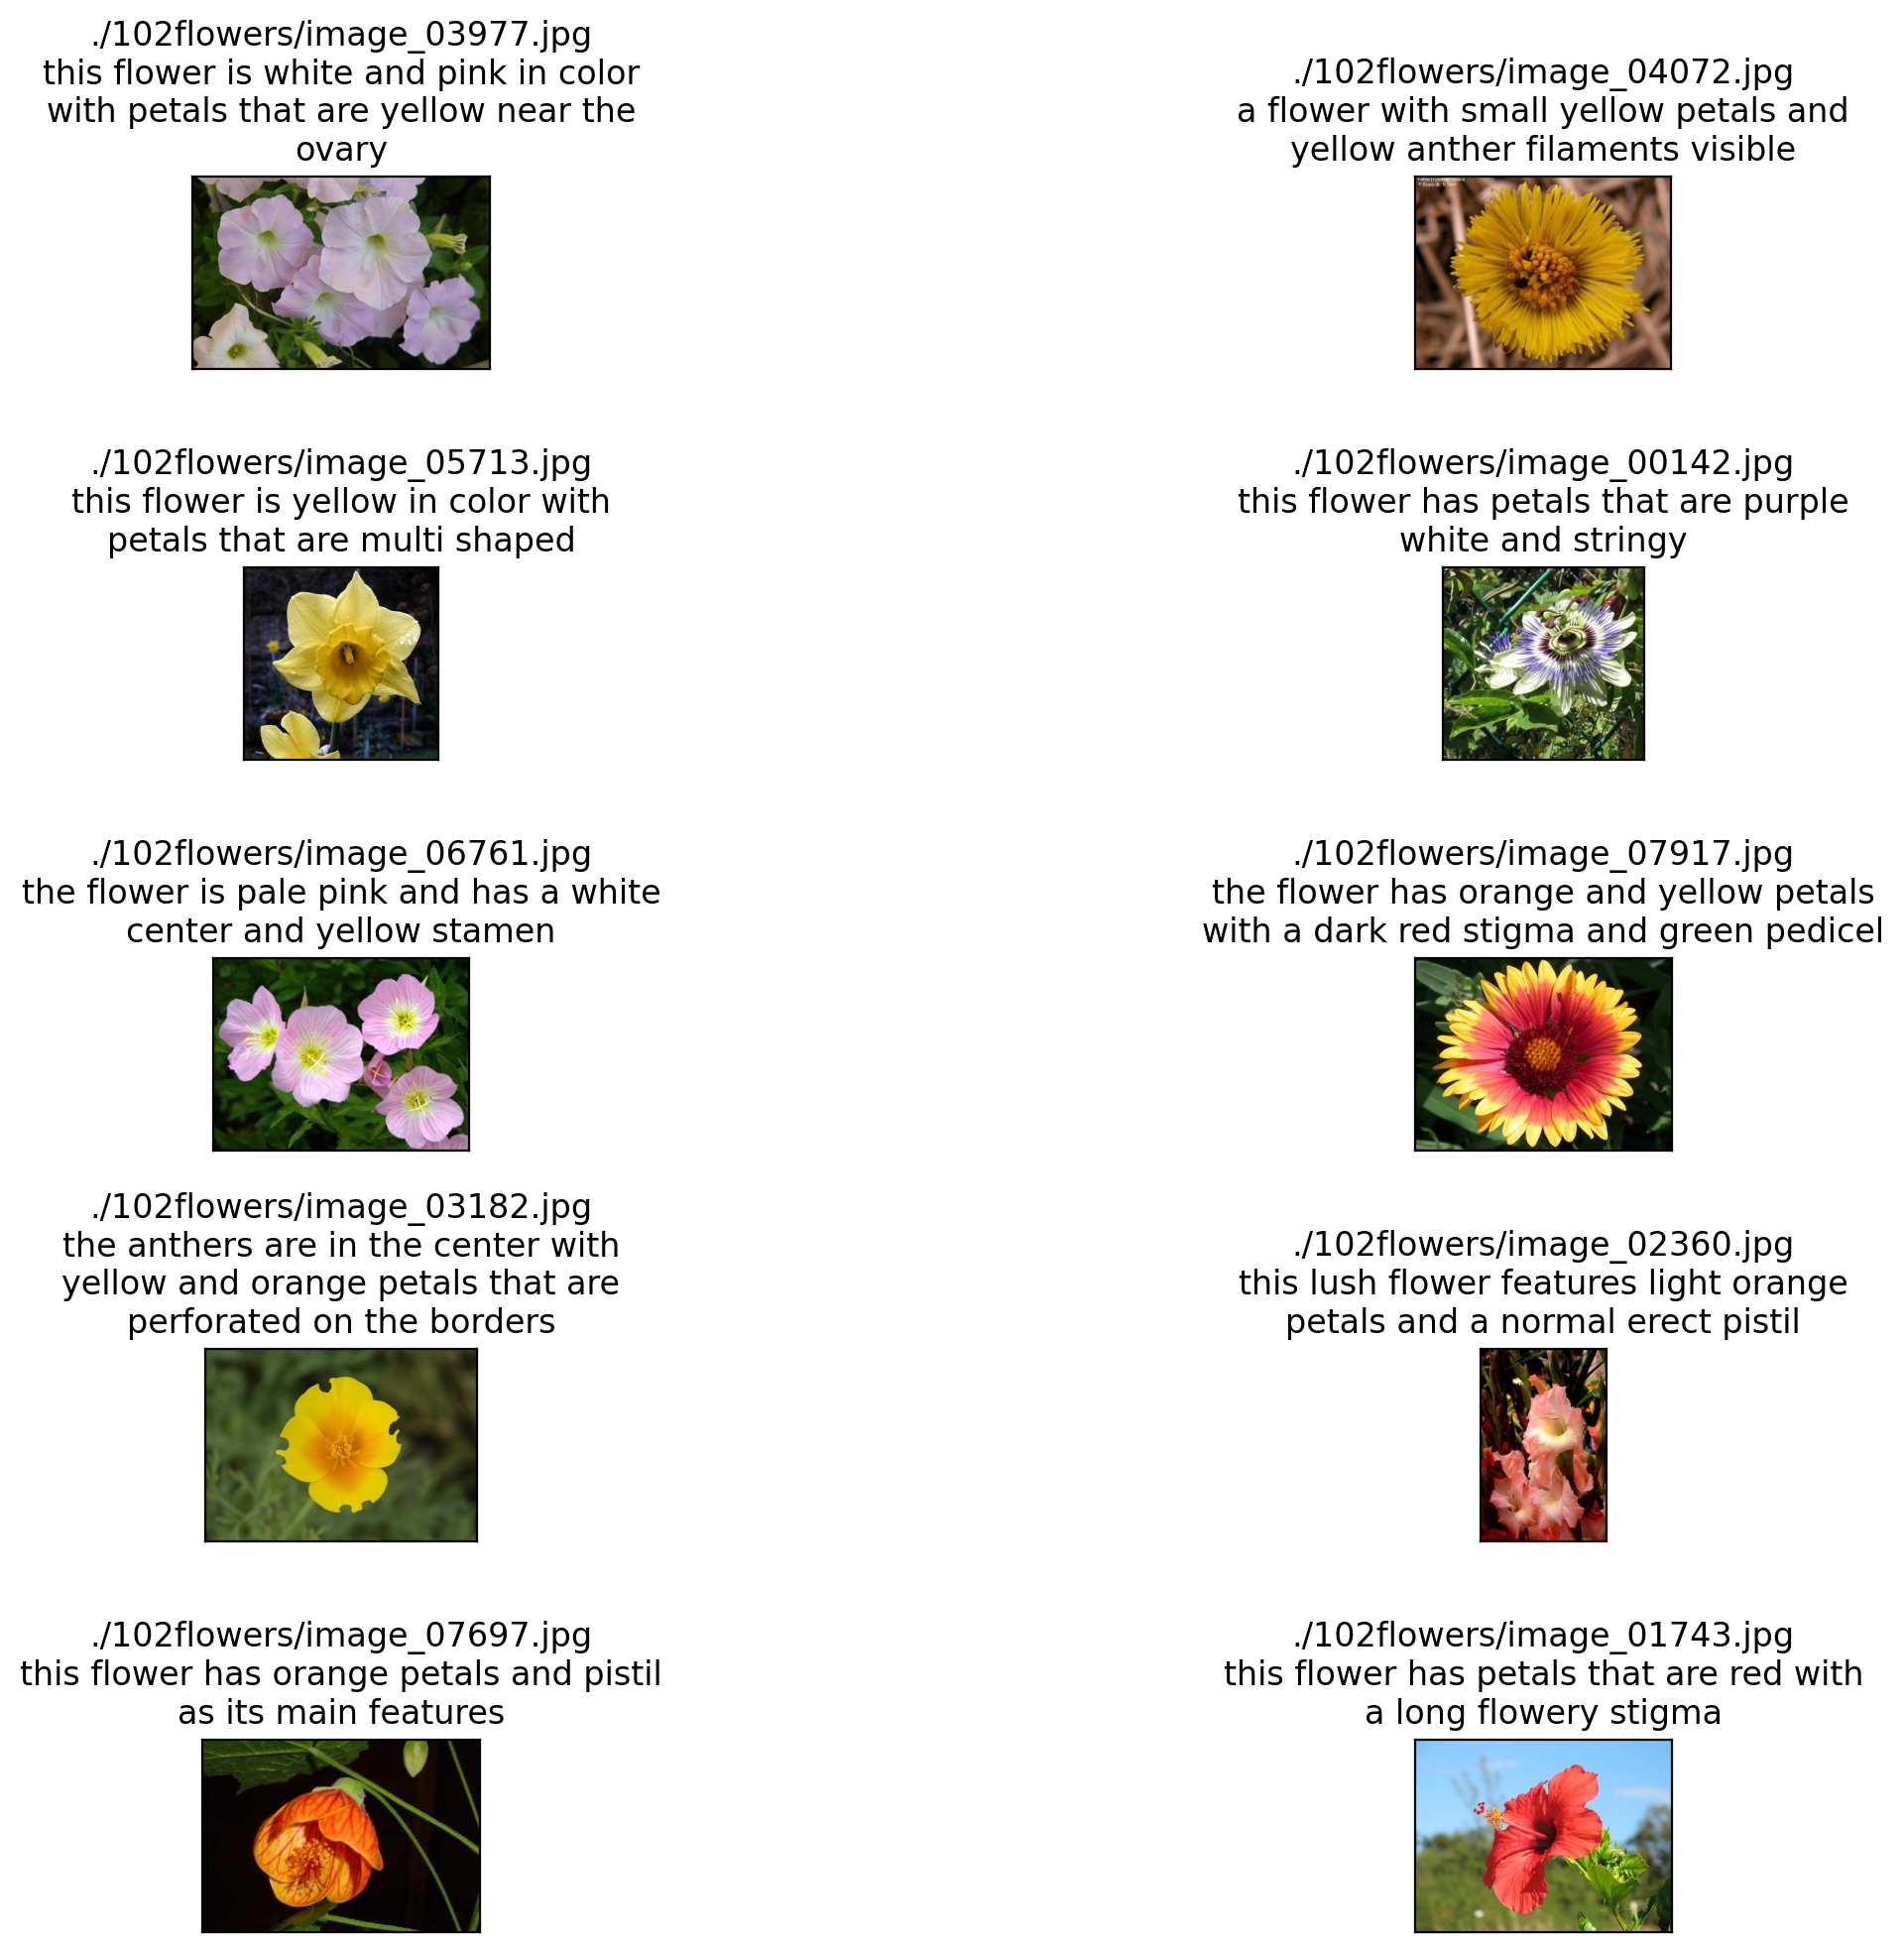

In [52]:
import textwrap
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 10))

for i, filename in enumerate(images_path):
    # name = os.path.splitext(filename)[0]
    # if name not in descriptions:
        # continue
    name = filename

    image = Image.open(filename).convert("RGB")

    wrapped_text = textwrap.fill(descriptions[i], width=40)
    plt.subplot(5, 2, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{wrapped_text}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[i])

plt.tight_layout()
print(texts)


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [53]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(texts).cuda()

In [54]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [55]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

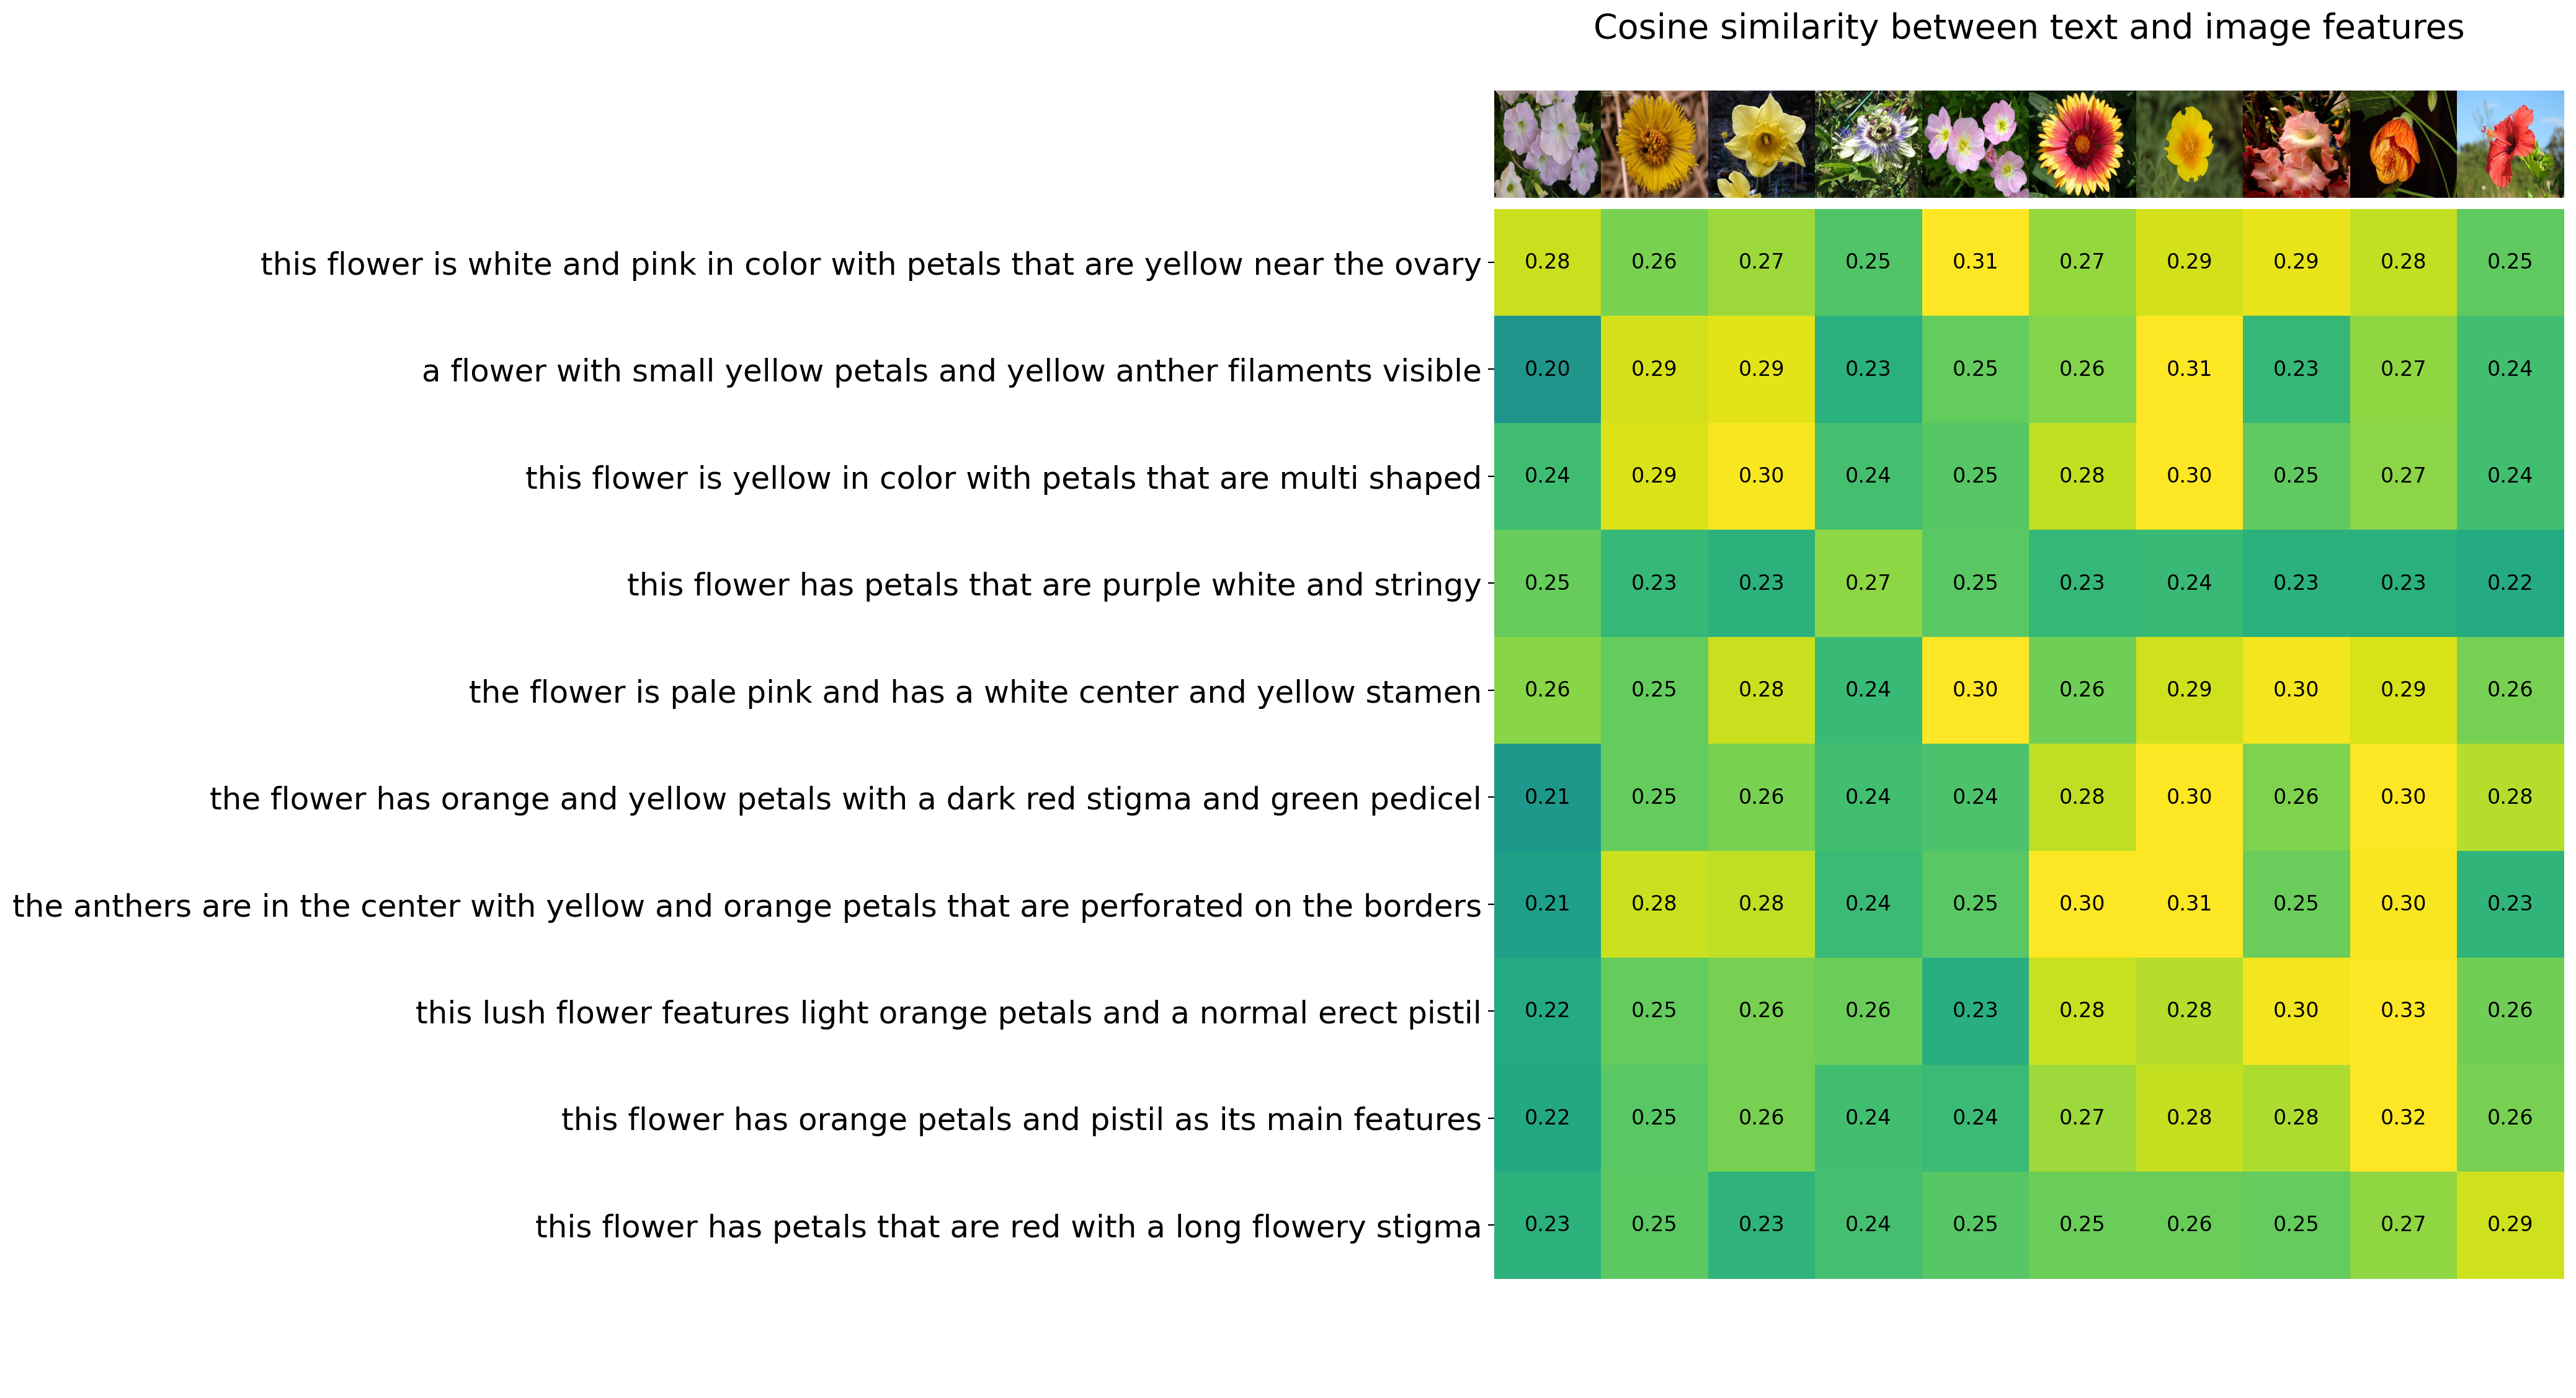

In [56]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

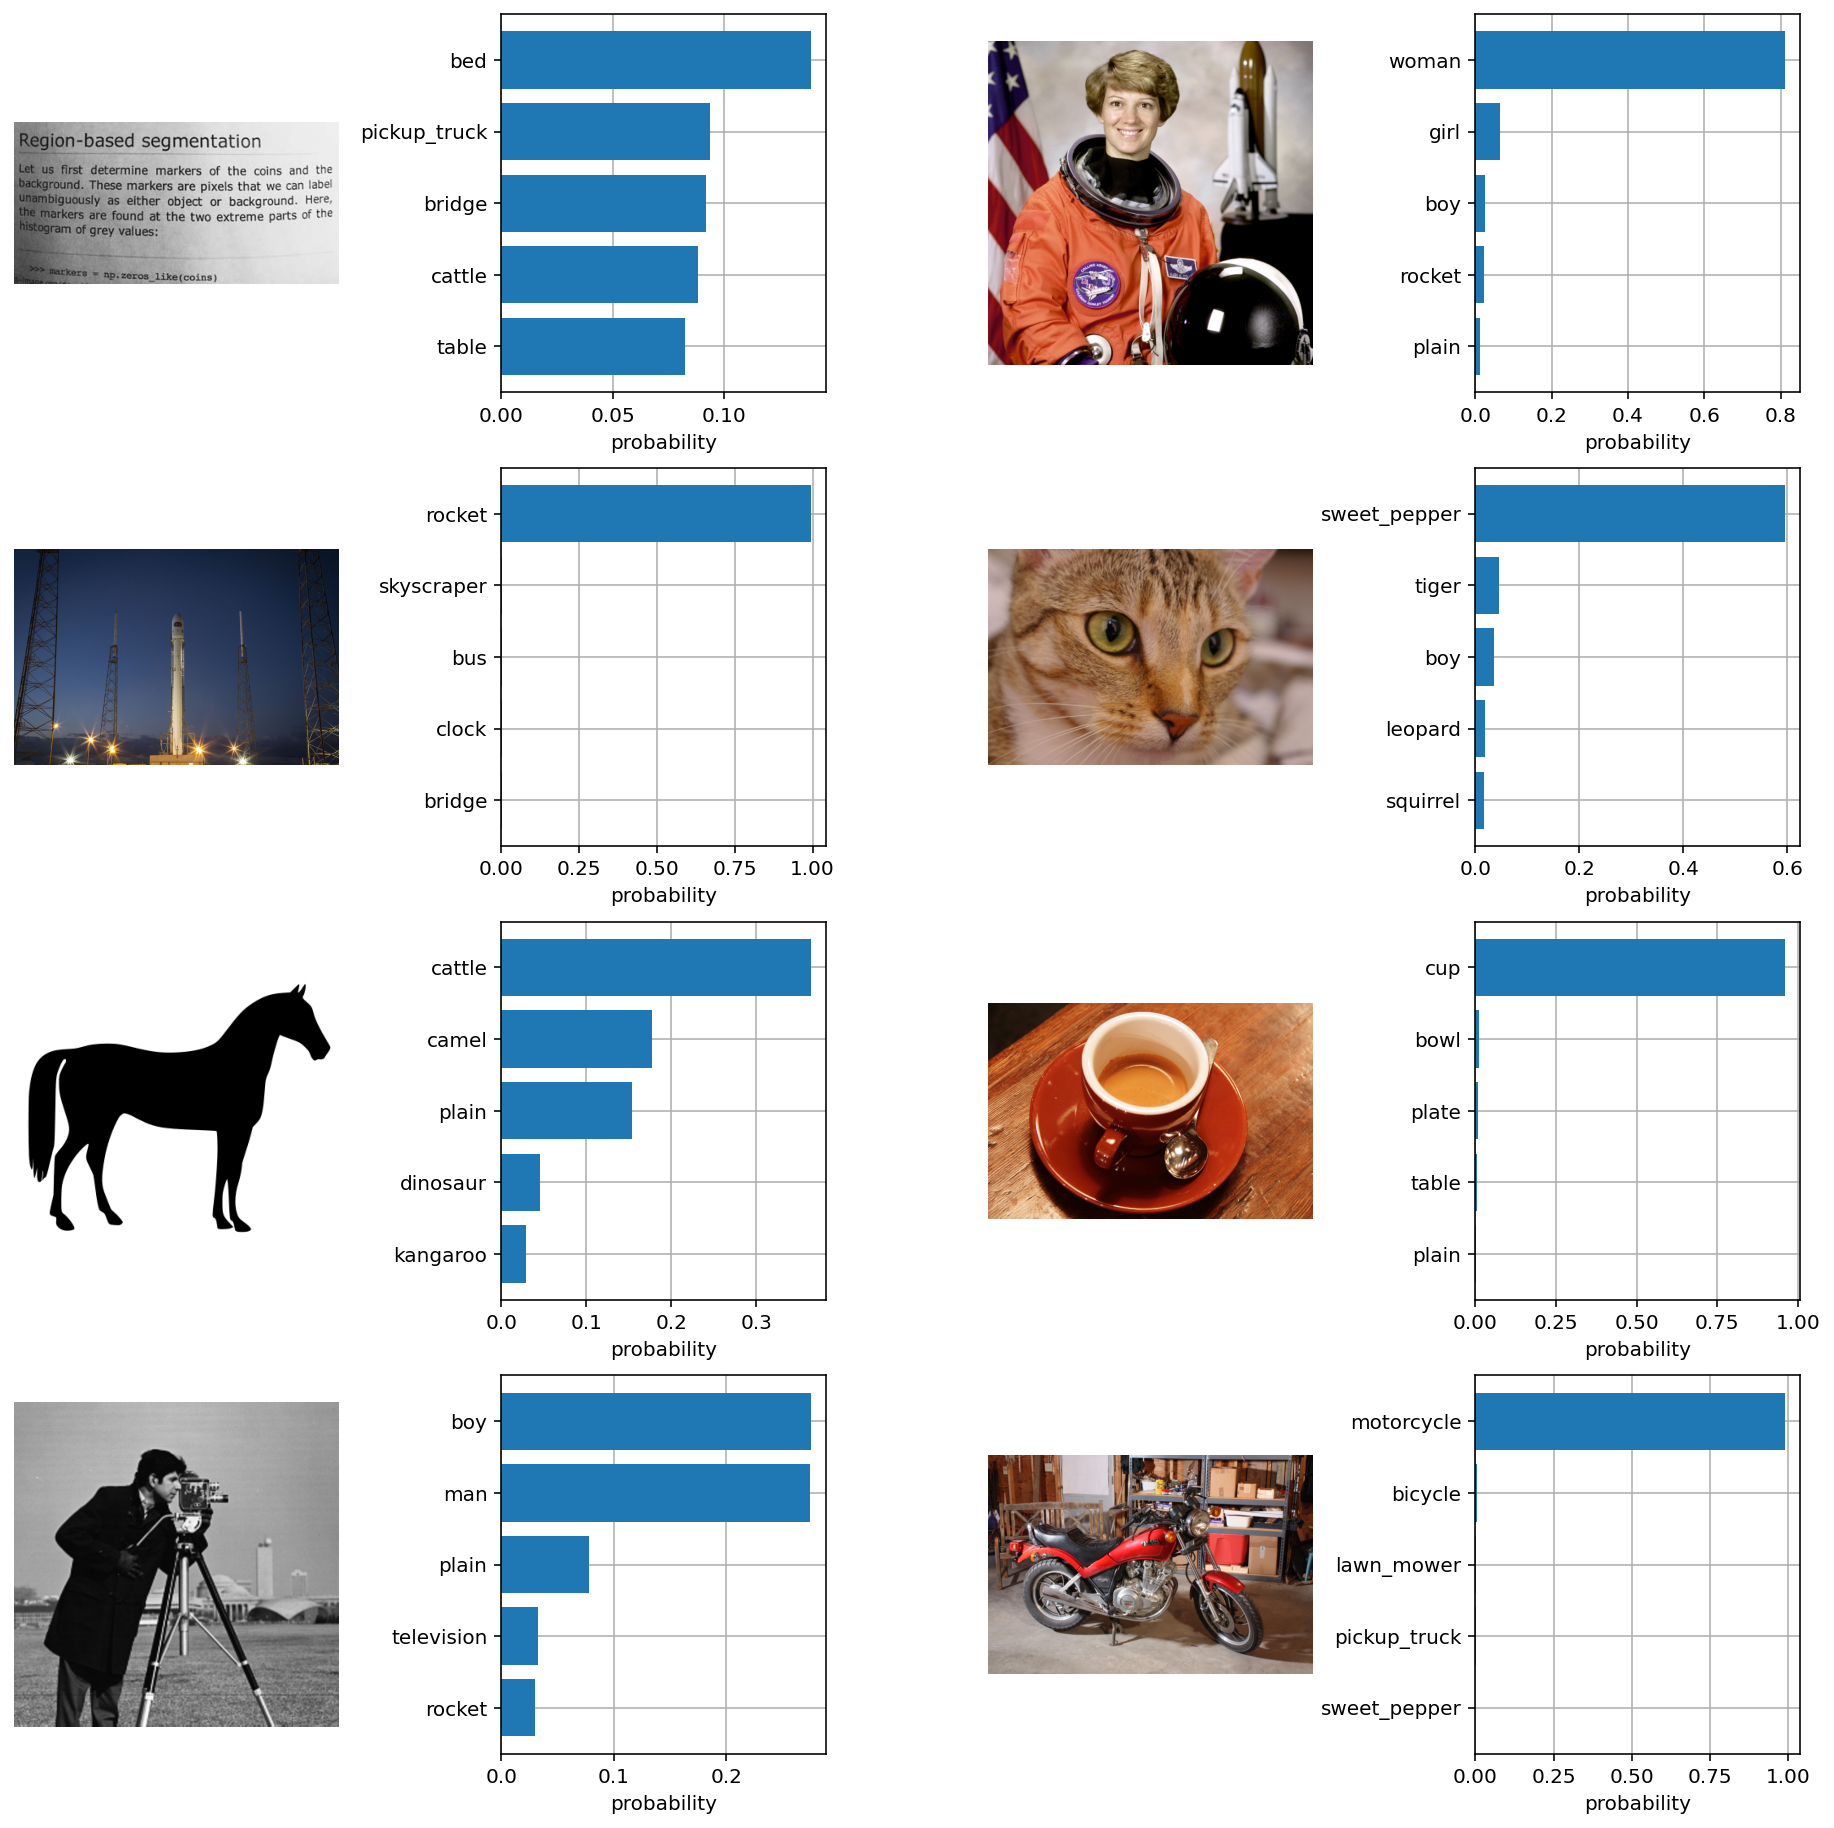

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()